In [1]:
import numpy as np
import chainer
from chainer import cuda, Function, gradient_check, report, training, utils, Variable
from chainer import datasets, iterators, optimizers, serializers
from chainer import Link, Chain, ChainList
import chainer.functions as F
import chainer.links as L
from chainer.training import extensions
from matplotlib import pyplot as plt
%matplotlib inline 
xp = cuda.cupy
import time


def model_func(model):
    if xp == np:
        pass
    else :
        gpu_device = 0
        cuda.get_device(gpu_device).use()
        model.to_gpu(gpu_device)
xp.model_init = model_func
xp.pi = np.pi

In [2]:
from chainer.utils import type_check
class ELU(Function):

    """Exponential Linear Unit."""
    # https://github.com/muupan/chainer-elu

    def __init__(self, alpha=1.0):
        self.alpha = xp.float32(alpha)

    def check_type_forward(self, in_types):
        type_check.expect(in_types.size() == 1)
        x_type, = in_types

        type_check.expect(
            x_type.dtype == xp.float32,
        )

    def forward_cpu(self, x):
        y = x[0].copy()
        neg_indices = x[0] < 0
        y[neg_indices] = self.alpha * (xp.exp(y[neg_indices]) - 1)
        return y,

    def forward_gpu(self, x):
        y = cuda.elementwise(
            'T x, T alpha', 'T y',
            'y = x >= 0 ? x : alpha * (exp(x) - 1)', 'elu_fwd')(
                x[0], self.alpha)
        return y,

    def backward_cpu(self, x, gy):
        gx = gy[0].copy()
        neg_indices = x[0] < 0
        gx[neg_indices] *= self.alpha * xp.exp(x[0][neg_indices])
        return gx,

    def backward_gpu(self, x, gy):
        gx = cuda.elementwise(
            'T x, T gy, T alpha', 'T gx',
            'gx = x >= 0 ? gy : gy * alpha * exp(x)', 'elu_bwd')(
                x[0], gy[0], self.alpha)
        return gx,


def elu(x, alpha=1.0):
    """Exponential Linear Unit function."""
    # https://github.com/muupan/chainer-elu
    #return ELU(alpha=alpha)(x)
    return F.leaky_relu(x)
    #return F.relu(x)

In [3]:
train,test = chainer.datasets.get_mnist()

In [4]:
dat = xp.array([ it[0] for it in train ]).astype(np.float32)

In [5]:
def get_dat(dat,size = 50):
    N = dat.shape[0]
    r = np.random.randint(N//50)
    return dat[r*size:(r+1)*size].reshape(-1,1,28,28)

In [16]:
def wreset(dat,sigma = 0.01):
    w = dat.W.data
    std = xp.std(w)
    w.data *= sigma / std
    print (xp.mean(xp.absolute(w)))
    
def wclip(dat,a = 0.01):
    w = dat.W.data
    w[w>a]=a
    w[w<-a]=-a


nz = 5
class Gen(Chain):
    def __init__(this):
        super().__init__(
            l1 = L.Linear(nz,128*4*4),
            #l2 = L.Linear(64,128*4*4),
            c7 = L.Deconvolution2D(128,64,3,stride=2,pad = 1),
            c8 = L.Deconvolution2D(64,32,4,stride=2,pad=1),
            c9 = L.Deconvolution2D(32,8,4,stride=2,pad=1),
            ce1= L.Deconvolution2D(8,16,3,stride=1,pad=1),
            ce2= L.Deconvolution2D(16,1,3,stride=1,pad=1),
        )
    
    def __call__(this,x):
        h = this.l1(x)
        #h = this.l2(h)
        h = F.reshape(h,(h.data.shape[0],128,4,4))
        #print ( h.data.shape)
        h = this.c7(elu(h))
        h = this.c8(elu(h))
        #print ( h.data.shape)
        h = this.c9(elu(h))
        h = this.ce1(elu(h))
        y = this.ce2(elu(h))
        #print ( y.data.shape)
        return y

class Dis(Chain):
    def __init__(this):
        super().__init__(
            c0 = L.Convolution2D(1,32,4,stride=2,pad=1),
            c1 = L.Convolution2D(32,64,4,stride=2,pad=1),
            c2 = L.Convolution2D(64,128,3,stride=2,pad=1),
            l2 = L.Linear(128*4*4, 64), #next add layer (64,64)
            l23 = L.Linear(64,64),
            l3 = L.Linear(64,1),#????????(64,3)
        )
        list(map(wreset,this.children()))

    
    def wclip(this):
        list(map(wclip,this.children()))
        
    def __call__(this,x):
        N = x.data.shape[0]
        h = F.reshape(x,(N,1,28,28))
        h = this.c0(h)
        h = this.c1(elu(h))
        h = this.c2(elu(h))
        h = F.reshape(h,(N,-1))
        #print (h.shape)
        h = this.l2(elu(h))
        h = this.l23(elu(h))
        y = this.l3(elu(h))
        return y  
gen = Gen()
dis = Dis()

xp.model_init(gen)
xp.model_init(dis)

lr = 0.00005
o_gen = optimizers.RMSprop(lr=lr)
o_gen.setup(gen)
o_gen.add_hook(chainer.optimizer.WeightDecay(0.0001))

o_dis = optimizers.RMSprop(lr=lr)
o_dis.setup(dis)
o_dis.add_hook(chainer.optimizer.WeightDecay(0.0001))

c = 0

0.00807334
0.00797948
0.00798959
0.00797305
0.00804915
0.00816819


/nfs/home/endo/.pyenv/versions/anaconda3-4.3.1/lib/python3.6/site-packages/ipykernel/__main__.py:4: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


In [17]:



stp = 1000 * 10
prt = 100
size = 50

critic = 2

for i in range(stp):
    c+=1
    for j in range(critic):
        z = Variable(xp.random.uniform(-1,1,(size,nz),dtype=np.float32))
        x1 = gen(z)
        y1 = dis(x1)

        x2 = Variable(get_dat(dat,size))
        y2= dis(x2) 

        bs = y1.shape[0]
        bsd= y2.shape[0]
        assert bs == bsd
        
        L_dis = -F.sum(y2 - y1)/bs #maxmize y2-y1
        L_gen = -F.sum(y1)/bs #maxmize y1

        dis.cleargrads()
        L_dis.backward()
        o_dis.update()
        
        dis.wclip()
        
        if j == critic -1 :
            gen.cleargrads()
            L_gen.backward()
            o_gen.update()
    
    if c % prt == 0 or c == 1:
        print ("{},{},{},W:{}".format(c,L_gen.data,L_dis.data,np.average(np.absolute(cuda.to_cpu(dis.l3.W.data)))))
        

1,4.181400072411634e-06,-1.3448375568714255e-07,W:0.006437688134610653
50,0.019071605056524277,-0.10811355710029602,W:0.009999998845160007
100,0.045686691999435425,0.007756499107927084,W:0.009561914950609207
150,0.026349836960434914,0.0029730689711868763,W:0.008495977148413658
200,0.01886844076216221,-0.001165898167528212,W:0.008066306822001934
250,0.025036433711647987,-0.000515538384206593,W:0.00809399876743555
300,0.039447735995054245,-0.0019061688799411058,W:0.008844148367643356
350,0.09055173397064209,-0.00237263273447752,W:0.009999998845160007
400,0.12344460189342499,-0.005455981474369764,W:0.009999998845160007
450,0.13035151362419128,-0.005669399164617062,W:0.009999998845160007
500,0.12082764506340027,-0.0065553211607038975,W:0.009999998845160007
550,0.1192433312535286,-0.007758232299238443,W:0.009999998845160007
600,0.12379397451877594,-0.0077127134427428246,W:0.009999998845160007
650,0.12980106472969055,-0.008122555911540985,W:0.009999998845160007
700,0.1296195238828659,-0.0085

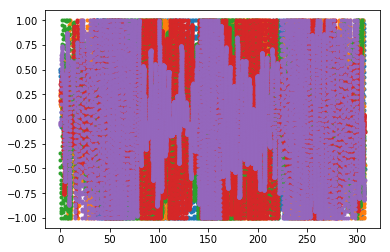

In [24]:
P = 10000

H = 5
p = xp.random.uniform(-1,1,(1,nz),dtype=np.float32)
v = xp.random.uniform(-1,1,(1,nz),dtype=np.float32) 
sp = xp.sum(p**2)
sv = xp.sum(v**2)
#alp = xp.sqrt( (sp+sv-H)/sv + 1 )
alp = 1.0
v *= alp
dt = 0.1
t = 0

li = []
lt = []

for i in range(P):
    sdt = dt / xp.sqrt(xp.sum(v**2))
    t += sdt
    p += sdt * v
    v += sdt * ( - 2 * p + xp.random.randn(nz) * 2 )
    v[p>1]*=-1
    v[p<-1]*=-1
    p[p>1] = 1
    p [p<-1] = -1
    li.append(cuda.to_cpu(p))
    lt.append(cuda.to_cpu(t))
    if 1 == 0 and i % 50 == 0:
        z = Variable(xp.random.uniform(-1,1,(1,nz),dtype=np.float32) * 1)
        z = Variable(p.astype(np.float32).reshape(1,-1))

        print (i,z.data)
        x = gen(z)
        _x = cuda.to_cpu(x.data[0].reshape(28,-1))
        plt.imshow(_x,cmap="Greys")
        if 1 == 0:
            import  scipy.misc as sm
            plt.imsave("img4/{}.png".format(i),_x,cmap="Greys")
        plt.show()
    
li = np.array(li).reshape(-1,5)
lt = np.array(lt).reshape(-1)
plt.plot(lt,li,".")